In [447]:
import pandas as pd
import numpy as np
import sys
import os
import time
import xgboost

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import model_selection 
import itertools
import gc
import pickle
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import re
from sklearn.model_selection import StratifiedKFold
from matplotlib import use
use("Agg")
import matplotlib.pyplot as plt
import csv,argparse,os,shutil
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import csv,argparse,os,shutil
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold

/Users/sangam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sangam/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sangam/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sangam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sangam/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sangam/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in 

In [505]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [448]:
df = pd.read_json('train.json').set_index('id')
test_df = pd.read_json('test.json').set_index('id')
label=df['cuisine']
traindex = df.index
testdex = test_df.index
print("Training Data Shape: ",df.shape)
print("Testing Data Shape: ", test_df.shape)
master = pd.concat([df.drop("cuisine", axis=1), test_df], axis=0)

Training Data Shape:  (39774, 2)
Testing Data Shape:  (9944, 1)


In [449]:
features = [] # list of list containg the recipes
for item in df['ingredients']:
    features.append(item)

In [450]:
features_test = [] # list of lists containg the recipes
for item in test_df['ingredients']:
    features_test.append(item)

In [451]:
features_processed= [] # here we will store the preprocessed training features
for item in features:
    newitem = []
    for ingr in item:
        ingr.lower() # Case Normalization - convert all to lower case 
        ingr = re.sub("[^a-zA-Z]"," ",ingr) # Remove punctuation, digits or special characters 
        ingr = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', ingr) # Remove different units  
        newitem.append(ingr)
    features_processed.append(newitem)

# Test 
features_test_processed= [] 
for item in features_test:
    newitem = []
    for ingr in item:
        ingr.lower() 
        ingr = re.sub("[^a-zA-Z]"," ",ingr)
        ingr = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', ingr) 
        newitem.append(ingr)
    features_test_processed.append(newitem) 

In [452]:
vectorizer = TfidfVectorizer(analyzer = "word",
                             ngram_range = (1,1), # unigrams
                             binary = True, #  (the default is counts)
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,  
                             max_df = 0.99)


In [453]:
train_X = vectorizer.fit_transform([str(i) for i in features_processed])
test_X =  vectorizer.transform([str(i) for i in features_test_processed])

In [454]:
lb = LabelEncoder()
train_Y = lb.fit_transform(label)

In [73]:

from threading import Timer

from sklearn.model_selection import RandomizedSearchCV
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [1.5, 2, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [5,7,10]
        }
xgb = xgb.XGBClassifier(learning_rate=0.02, n_estimators=100, objective='multi:softmax',
                    silent=True, eval_metrix='merror',num_class=20)
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(train_X,train_Y), verbose=3, random_state=1001 )
random_search.fit(train_X, train_Y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=1.5, colsample_bytree=0.6 
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=1.5, colsample_bytree=0.6 
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=1.5, colsample_bytree=0.6 
[CV] subsample=1.0, min_child_weight=1, max_depth=7, gamma=1.5, colsample_bytree=0.6 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=1.5, colsample_bytree=0.6, score=0.6944716796138471, total= 2.4min
[CV] subsample=1.0, min_child_weight=1, max_depth=7, gamma=1.5, colsample_bytree=0.6 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=1.5, colsample_bytree=0.6, score=0.6928765469363115, total= 2.4min
[CV] subsample=1.0, min_child_weight=1, max_depth=7, gamma=1.5, colsample_bytree=0.6 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=1.5, colsample_bytree=0.6, score=0.6953178014023976, total= 2.4min
[CV] subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=1.0, min_child_weight=1, max_depth=7, gamma=1.5, colsample_bytree=0.6, score=0.7235919475231848, total= 3.5min
[CV] subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8, score=0.6838573475081052, total= 2.8min
[CV] subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=1.0, min_child_weight=1, max_depth=7, gamma=1.5, colsample_bytree=0.6, score=0.729315936345124, total= 3.4min
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=1.0, min_child_weight=1, max_depth=7, gamma=1.5, colsample_bytree=0.6, score=0.7219287654693631, total= 3.5min
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8, score=0.687306735047892, total= 2.8min
[CV] subsample=1.0, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8, score=0.6879716269242379, total= 2.9min
[CV] subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.6 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8, score=0.6879100988008146, total= 3.2min
[CV] subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.6 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8, score=0.6882304154414537, total= 3.2min
[CV] subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.6 


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=1.0, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.8, score=0.6876697856927256, total= 3.2min


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.6897383699012289, total= 2.2min


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.6907760766271966, total= 2.1min


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, min_child_weight=5, max_depth=5, gamma=2, colsample_bytree=0.6, score=0.6904618170842137, total= 2.1min


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 11.5min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x1a1817d0a0>,
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metrix='merror', gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=20, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=5, n_jobs=4,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [1.5, 2, 5], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.6, 0.8], 'max_depth': [5, 7, 10]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=3)

In [134]:
results = pd.DataFrame(random_search.cv_results_)
results


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sangam/anaconda3/lib/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,188.466825,0.389708,63.254159,0.053980,rbf,0.001,1,"{'kernel': 'rbf', 'gamma': 0.001, 'C': 1}",0.231923,0.232069,0.235210,0.233067,0.001516,5,0.232092,0.233604,0.233730,0.233142,0.000744
1,65.526892,1.090659,31.039260,0.391263,linear,0.0001,100,"{'kernel': 'linear', 'gamma': 0.0001, 'C': 100}",0.739048,0.732710,0.743209,0.738322,0.004316,3,0.974841,0.975599,0.974889,0.975109,0.000347
2,57.097391,0.109731,33.739069,0.048951,linear,0.001,1,"{'kernel': 'linear', 'gamma': 0.001, 'C': 1}",0.786700,0.783619,0.783504,0.784608,0.001480,1,0.851232,0.852461,0.853970,0.852554,0.001120
3,57.128737,0.103506,33.284195,0.028240,linear,0.0001,1,"{'kernel': 'linear', 'gamma': 0.0001, 'C': 1}",0.786700,0.783619,0.783504,0.784608,0.001480,1,0.851232,0.852461,0.853970,0.852554,0.001120
4,184.394901,2.184468,62.027835,0.352231,rbf,0.0001,10,"{'kernel': 'rbf', 'gamma': 0.0001, 'C': 10}",0.232225,0.232672,0.235587,0.233494,0.001491,4,0.232545,0.233943,0.233957,0.233482,0.000662


In [106]:
model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metrix='merror', gamma=1.5,
       learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, num_class=20, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

for train_index, test_index in skf.split(train_X, train_Y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = train_Y[train_index], train_Y[test_index]
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    print ("Accuracy : %.4g" % accuracy_score(y_train,train_pred))
    print ("Accuracy : %.4g" % accuracy_score(y_test,test_pred))

/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.7009
Accuracy : 0.6792


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.7016
Accuracy : 0.6794


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.703
Accuracy : 0.6836


/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [170]:

param_grid = {
  'C': [1, 10, 100], 
  'fit_intercept': ['True','False'],
    'penalty' : ['l1','l2']
    }
model=LogisticRegression(random_state = 42)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(train_X,train_Y), verbose=3, random_state=1001 )
random_search.fit(train_X, train_Y)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] penalty=l2, fit_intercept=True, C=1 .............................
[CV] penalty=l2, fit_intercept=True, C=1 .............................
[CV] penalty=l2, fit_intercept=True, C=1 .............................
[CV] penalty=l2, fit_intercept=False, C=100 ..........................
[CV]  penalty=l2, fit_intercept=True, C=1, score=0.7741911154687382, total=   4.8s
[CV] penalty=l2, fit_intercept=False, C=100 ..........................
[CV]  penalty=l2, fit_intercept=True, C=1, score=0.777576717183141, total=   4.9s
[CV] penalty=l2, fit_intercept=False, C=100 ..........................
[CV]  penalty=l2, fit_intercept=True, C=1, score=0.7709779655900996, total=   4.9s
[CV] penalty=l1, fit_intercept=False, C=10 ...........................
[CV]  penalty=l2, fit_intercept=False, C=100, score=0.773731433310714, total=  13.1s
[CV] penalty=l1, fit_intercept=False, C=10 ...........................
[CV]  penalty=l2, fit_intercept=False, 

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   35.2s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x1b898c4ca8>,
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=4,
          param_distributions={'C': [1, 10, 100], 'fit_intercept': ['True', 'False'], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=3)

In [201]:
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier

#vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(C=5,penalty='l2',random_state = 42)),
#                                  ('clf2',SVC(kernel='linear',C=1.5,random_state = 42,probability=True)),
                                  #('clf3',RandomForestClassifier(n_estimators = 600,random_state = 42))
 #                                ], 
  #                                  voting='soft', weights = [1,1]) 
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
model = OneVsRestClassifier(classifier)
#model=SVC(C=1.5, kernel='linear')
#model=LogisticRegression(C=5,penalty='l2',random_state = 42)
#model=RandomForestClassifier(n_estimators = 100,random_state = 42)
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

for train_index, test_index in skf.split(train_X, train_Y):
    X_train, X_test = train_X[train_index], train_X[test_index]
    y_train, y_test = train_Y[train_index], train_Y[test_index]
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    print ("Accuracy : %.4g" % accuracy_score(y_train,train_pred))
    print ("Accuracy : %.4g" % accuracy_score(y_test,test_pred))

Accuracy : 0.9998
Accuracy : 0.8189
Accuracy : 0.9996
Accuracy : 0.808
Accuracy : 0.9997
Accuracy : 0.8118


In [455]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
model = OneVsRestClassifier(classifier)
X_train,X_test,y_train,y_test = train_test_split(train_X, train_Y,test_size=0.2)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred=lb.inverse_transform(y_pred)
y_test=lb.inverse_transform(y_test)
y_train=lb.inverse_transform(y_train)
a=confusion_matrix(y_test, y_pred,labels=['brazilian',
 'british',
 'cajun_creole',
 'chinese',
 'filipino',
 'french',
 'greek',
 'indian',
 'irish',
 'italian',
 'jamaican',
 'japanese',
 'korean',
 'mexican',
 'moroccan',
 'russian',
 'southern_us',
 'spanish',
 'thai',
 'vietnamese'])
a=pd.DataFrame(a)
a.to_csv('sv_confusion_matrix.csv')

/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [541]:
cuisine_sim={}
cuis_1=['chinese','japanese','korean','thai','vietnamese','filipino']
cuis_2=['greek','italian','french','spanish','brazilian']
cuis_3=['british','russian','irish']
cuis_4=['jamaican','cajun_creole','mexican','southern_us']
cuis_5=['indian','moroccan']
for val in cuis_1:
    cuisine_sim[val]=1
for val in cuis_2:
    cuisine_sim[val]=2
for val in cuis_3:
    cuisine_sim[val]=3
for val in cuis_4:
    cuisine_sim[val]=4
for val in cuis_5:
    cuisine_sim[val]=5

In [537]:
col=['chinese','japanese','korean','thai','vietnamese','filipino','indian','moroccan']

print(accuracy_score(y_test[np.isin(y_pred,col)],
               y_pred[np.isin(y_pred,col)]))
south_asian=X_train[np.isin(y_train,col)]
south_asian_y=y_train[np.isin(y_train,col)]
south_asian_test=X_test[np.isin(y_pred,col)]
south_asian_test_y=y_test[np.isin(y_pred,col)]
south_asian_test_y = lb.transform(south_asian_test_y)
south_asian_y = lb.transform(south_asian_y)
lr_sa=LogisticRegression(C=6,penalty='l2',random_state = 42)
svc=SVC(kernel='linear',C=1.5,random_state = 42)
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
ovr = OneVsRestClassifier(classifier)
rf=RandomForestClassifier(n_estimators = 10,random_state = 42)        
#south_asian_y = lb.transform(south_asian_y)
svc.fit(south_asian,south_asian_y)
y_pred_sa = svc.predict(south_asian_test)
y_sa = svc.predict(south_asian)

print(accuracy_score(south_asian_y,y_sa))
print(accuracy_score(south_asian_test_y,y_pred_sa))


0.834332191780822
0.9039292109975772
0.8133561643835616


In [510]:
X_train,X_test,y_train,y_test

array(['mexican', 'spanish', 'southern_us', ..., 'mexican', 'mexican',
       'mexican'], dtype=object)

In [495]:
print(accuracy_score(y_test,y_pred))

0.8143306096794469


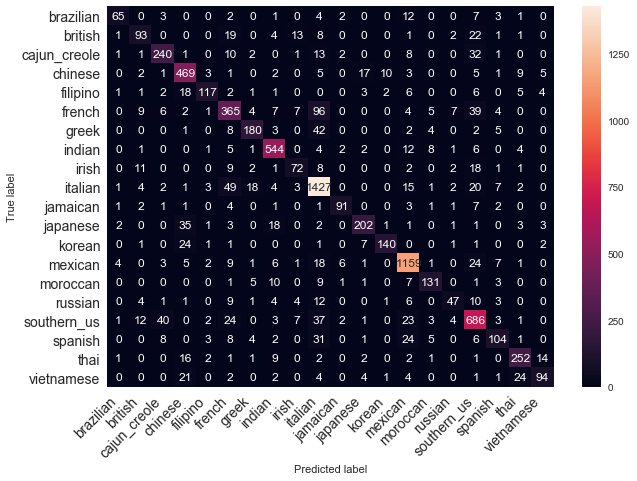

In [506]:
sns.set(style="white")
a=confusion_matrix(y_test,y_pred)
print_confusion_matrix(a,['brazilian',
 'british',
 'cajun_creole',
 'chinese',
 'filipino',
 'french',
 'greek',
 'indian',
 'irish',
 'italian',
 'jamaican',
 'japanese',
 'korean',
 'mexican',
 'moroccan',
 'russian',
 'southern_us',
 'spanish',
 'thai',
 'vietnamese'])
a=np.where(a>20,1,0)
comp=connected_components(a)

In [507]:
value=comp[1]
keys=['brazilian',
 'british',
 'cajun_creole',
 'chinese',
 'filipino',
 'french',
 'greek',
 'indian',
 'irish',
 'italian',
 'jamaican',
 'japanese',
 'korean',
 'mexican',
 'moroccan',
 'russian',
 'southern_us',
 'spanish',
 'thai',
 'vietnamese']

sim = dict(zip(keys, value))

In [548]:
cuisine_sim

{'chinese': 1,
 'japanese': 1,
 'korean': 1,
 'thai': 1,
 'vietnamese': 1,
 'filipino': 1,
 'greek': 2,
 'italian': 2,
 'french': 2,
 'spanish': 2,
 'brazilian': 2,
 'british': 3,
 'russian': 3,
 'irish': 3,
 'jamaican': 4,
 'cajun_creole': 4,
 'mexican': 4,
 'southern_us': 4,
 'indian': 5,
 'moroccan': 5}

In [547]:
train_connected=np.vectorize(cuisine_sim.get)(y_train)
test_connected=np.vectorize(cuisine_sim.get)(y_test)
svc=SVC(kernel='linear',C=1.5,random_state = 42)
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
ovr = OneVsRestClassifier(classifier)
lr_sa=LogisticRegression(C=10,penalty='l2',random_state = 42)

ovr.fit(X_train,train_connected)

print(accuracy_score(ovr.predict(X_train),train_connected))
print(accuracy_score(ovr.predict(X_test),test_connected))

0.9998114334202834
0.9054682589566311


In [542]:
print(accuracy_score(np.vectorize(cuisine_sim.get)(y_pred),np.vectorize(cuisine_sim.get)(y_test)))

0.9058453802639849


In [570]:
df={'ovr_1':lb.inverse_transform(ovr1.predict(X_test)),
    'ovr_2':lb.inverse_transform(ovr2.predict(X_test)),
    'ovr_3':lb.inverse_transform(ovr3.predict(X_test)),
    'ovr_4':lb.inverse_transform(ovr4.predict(X_test)),
    'ovr_5':lb.inverse_transform(ovr5.predict(X_test)),
    'actual':y_test,
    'old_model':y_pred
   }
df = pd.DataFrame(data=df)
df['old_model_key']=df['old_model'].map(cuisine_sim)
def final_output (row):
    col='ovr_'+str(row['old_model_key'])
    return row[col]
df['final_cuisine']=df.apply (lambda row: final_output (row),axis=1)

/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

In [579]:
accuracy_score(df['old_model'],df['actual'])

0.8143306096794469

In [606]:
accuracy_score(df['final_cuisine'],df['actual'])

0.8163419233186675

In [586]:
df['final_cuisine']=df['ovr_%s']

,ovr_1,ovr_2,ovr_3,ovr_4,ovr_5,actual,old_model,old_model_key
0,filipino,italian,irish,mexican,indian,mexican,mexican,4
1,chinese,spanish,british,southern_us,indian,spanish,spanish,2
2,japanese,french,british,southern_us,indian,southern_us,southern_us,4
3,vietnamese,italian,russian,mexican,indian,mexican,mexican,4
4,filipino,greek,russian,mexican,indian,greek,greek,2


In [565]:
col=[]

for key, value in cuisine_sim.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if value == 1:
        col.append(key)

print(accuracy_score(y_test[np.isin(y_pred,col)],
               y_pred[np.isin(y_pred,col)]))
south_asian=X_train[np.isin(y_train,col)]
south_asian_y=y_train[np.isin(y_train,col)]
south_asian_test=X_test[np.isin(y_pred,col)]
south_asian_test_y=y_test[np.isin(y_pred,col)]
south_asian_test_y = lb.transform(south_asian_test_y)
south_asian_y = lb.transform(south_asian_y)
lr_sa=LogisticRegression(C=6,penalty='l2',random_state = 42)
svc=SVC(kernel='linear',C=1,random_state = 42)
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
ovr1 = OneVsRestClassifier(classifier)
rf=RandomForestClassifier(n_estimators = 10,random_state = 42)        
#south_asian_y = lb.transform(south_asian_y)
ovr1.fit(south_asian,south_asian_y)
y_pred_sa = ovr1.predict(south_asian_test)
y_sa = ovr1.predict(south_asian)

print(accuracy_score(south_asian_y,y_sa))
print(accuracy_score(south_asian_test_y,y_pred_sa))




0.8198198198198198
0.999688909628247
0.8198198198198198


In [564]:
col=[]

for key, value in cuisine_sim.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if value == 2:
        col.append(key)

print(accuracy_score(y_test[np.isin(y_pred,col)],
               y_pred[np.isin(y_pred,col)]))
south_asian=X_train[np.isin(y_train,col)]
south_asian_y=y_train[np.isin(y_train,col)]
south_asian_test=X_test[np.isin(y_pred,col)]
south_asian_test_y=y_test[np.isin(y_pred,col)]
south_asian_test_y = lb.transform(south_asian_test_y)
south_asian_y = lb.transform(south_asian_y)
lr_sa=LogisticRegression(C=6,penalty='l2',random_state = 42)
svc=SVC(kernel='linear',C=1,random_state = 42)
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
ovr2 = OneVsRestClassifier(classifier)
rf=RandomForestClassifier(n_estimators = 10,random_state = 42)        
#south_asian_y = lb.transform(south_asian_y)
ovr2.fit(south_asian,south_asian_y)
y_pred_sa = ovr2.predict(south_asian_test)
y_sa = ovr2.predict(south_asian)

print(accuracy_score(south_asian_y,y_sa))
print(accuracy_score(south_asian_test_y,y_pred_sa))



0.792962962962963
0.9998087222647284
0.7951851851851852


In [561]:
col=[]

for key, value in cuisine_sim.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if value == 3:
        col.append(key)

print(accuracy_score(y_test[np.isin(y_pred,col)],
               y_pred[np.isin(y_pred,col)]))
south_asian=X_train[np.isin(y_train,col)]
south_asian_y=y_train[np.isin(y_train,col)]
south_asian_test=X_test[np.isin(y_pred,col)]
south_asian_test_y=y_test[np.isin(y_pred,col)]
south_asian_test_y = lb.transform(south_asian_test_y)
south_asian_y = lb.transform(south_asian_y)
lr_sa=LogisticRegression(C=6,penalty='l2',random_state = 42)
svc=SVC(kernel='linear',C=1,random_state = 42)
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
ovr3 = OneVsRestClassifier(classifier)
rf=RandomForestClassifier(n_estimators = 10,random_state = 42)        
#south_asian_y = lb.transform(south_asian_y)
ovr3.fit(south_asian,south_asian_y)
y_pred_sa = ovr3.predict(south_asian_test)
y_sa = ovr3.predict(south_asian)

print(accuracy_score(south_asian_y,y_sa))
print(accuracy_score(south_asian_test_y,y_pred_sa))




0.668769716088328
1.0
0.6719242902208202


In [562]:
col=[]

for key, value in cuisine_sim.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if value == 4:
        col.append(key)

print(accuracy_score(y_test[np.isin(y_pred,col)],
               y_pred[np.isin(y_pred,col)]))
south_asian=X_train[np.isin(y_train,col)]
south_asian_y=y_train[np.isin(y_train,col)]
south_asian_test=X_test[np.isin(y_pred,col)]
south_asian_test_y=y_test[np.isin(y_pred,col)]
south_asian_test_y = lb.transform(south_asian_test_y)
south_asian_y = lb.transform(south_asian_y)
lr_sa=LogisticRegression(C=6,penalty='l2',random_state = 42)
svc=SVC(kernel='linear',C=1,random_state = 42)
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
ovr4 = OneVsRestClassifier(classifier)
rf=RandomForestClassifier(n_estimators = 10,random_state = 42)        
#south_asian_y = lb.transform(south_asian_y)
ovr4.fit(south_asian,south_asian_y)
y_pred_sa = ovr4.predict(south_asian_test)
y_sa = ovr4.predict(south_asian)

print(accuracy_score(south_asian_y,y_sa))
print(accuracy_score(south_asian_test_y,y_pred_sa))

0.8362797847809378
0.9999029597282872
0.8385857033051499


In [563]:
col=[]

for key, value in cuisine_sim.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if value == 5:
        col.append(key)

print(accuracy_score(y_test[np.isin(y_pred,col)],
               y_pred[np.isin(y_pred,col)]))
south_asian=X_train[np.isin(y_train,col)]
south_asian_y=y_train[np.isin(y_train,col)]
south_asian_test=X_test[np.isin(y_pred,col)]
south_asian_test_y=y_test[np.isin(y_pred,col)]
south_asian_test_y = lb.transform(south_asian_test_y)
south_asian_y = lb.transform(south_asian_y)
lr_sa=LogisticRegression(C=6,penalty='l2',random_state = 42)
svc=SVC(kernel='linear',C=1,random_state = 42)
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
ovr5 = OneVsRestClassifier(classifier)
rf=RandomForestClassifier(n_estimators = 10,random_state = 42)        
#south_asian_y = lb.transform(south_asian_y)
ovr5.fit(south_asian,south_asian_y)
y_pred_sa = ovr5.predict(south_asian_test)
y_sa = ovr5.predict(south_asian)

print(accuracy_score(south_asian_y,y_sa))
print(accuracy_score(south_asian_test_y,y_pred_sa))

0.8631713554987213
1.0
0.8670076726342711


In [611]:
ovr.fit(train_X,train_Y)

OneVsRestClassifier(estimator=SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [618]:
col

['chinese', 'japanese', 'korean', 'thai', 'vietnamese', 'filipino']

In [625]:
for i in range(1,6):
    col=[]
    for key, value in cuisine_sim.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if value == i:
            col.append(key)
    print (i)
    x=train_X[np.isin(train_Y,col)]
    y=train_Y[np.isin(train_Y,col)]
    exec("ovr_%s=OneVsRestClassifier(classifier)" %(i))
    exec("ovr_%s.fit(x,y)" %(i))
    
    

5


In [628]:
ovr_1.predict(test_X)

array(['filipino', 'japanese', 'japanese', ..., 'japanese', 'filipino',
       'filipino'], dtype='<U10')

In [629]:
df={'ovr_1':ovr_1.predict(test_X),
    'ovr_2':ovr_2.predict(test_X),
    'ovr_3':ovr_3.predict(test_X),
    'ovr_4':ovr_4.predict(test_X),
    'ovr_5':ovr_5.predict(test_X),
    'old_model':lb.inverse_transform(ovr.predict(test_X))
   }
df = pd.DataFrame(data=df)
df['old_model_key']=df['old_model'].map(cuisine_sim)
def final_output (row):
    col='ovr_'+str(row['old_model_key'])
    return row[col]
df['final_cuisine']=df.apply (lambda row: final_output (row),axis=1)
results_df = pd.DataFrame(data={'id':testdex, 'cuisine':df['final_cuisine']})
results_df.to_csv('ensemble6SVC.csv', index=False)

/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [435]:
svm_ovr=pd.read_csv('submission-svm-ovr-tuned.csv')
train_Y_name=lb.inverse_transform(train_Y)
south_asian=train_X[np.isin(train_Y_name,col)]
south_asian_y=train_Y_name[np.isin(train_Y_name,col)]
south_asian_y=lb.transform(south_asian_y)
lr_sa.fit(south_asian, south_asian_y)
test_y = lr_sa.predict(test_X)
test_y=lb.inverse_transform(test_y)
results_df = pd.DataFrame(data={'id':testdex, 'cuisine':test_y})

/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [439]:
a=pd.merge(svm_ovr,results_df,on='id',how='left',suffixes=['','_sa'])

In [437]:
a['cuisine']=np.where(a['cuisine'].isin(col),a['cuisine_sa'],
                     a['cuisine'])
a[['id','cuisine']].to_csv('cajun_southern_diferent.csv',index=False)

In [223]:
classifier = SVC(C=100, # penalty parameter
                     kernel='rbf', # kernel type, rbf working fine here
                     degree=3, # default value
                     gamma=1, # kernel coefficient
                     coef0=1, # change to 1 from default value of 0.0
                     shrinking=True, # using shrinking heuristics
                     tol=0.001, # stopping criterion tolerance 
                     probability=True, # no need to enable probability estimates
                     cache_size=200, # 200 MB cache size
                     class_weight=None, # all classes are treated equally 
                     verbose=False, # print the logs 
                     max_iter=-1, # no limit, let it run
                     decision_function_shape=None, # will use one vs rest explicitly 
                random_state=None)
model = OneVsRestClassifier(classifier)
vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(C=5,penalty='l2',random_state = 42)),
                                 ('clf2',model),
                                  ('clf3',RandomForestClassifier(n_estimators = 600,random_state = 42))
                                 ], 
                                    voting='soft', weights = [1,1,1]) 
vclf.fit(train_X, train_Y)

VotingClassifier(estimators=[('clf1', LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('clf2', OneVsRe...timators=600, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 1, 1])

In [204]:
y_test = model.predict(test_X)
y_test=lb.inverse_transform(y_test)
results_df = pd.DataFrame(data={'id':testdex, 'cuisine':y_test})
results_df.to_csv('submission-svm-ovr-tuned.csv', index=False)

/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [224]:
y_test = vclf.predict(test_X)
y_test=lb.inverse_transform(y_test)
results_df = pd.DataFrame(data={'id':testdex, 'cuisine':y_test})
results_df.to_csv('submission-vclf-tuned-ovr-lr-rf.csv', index=False)

/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sangam/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
